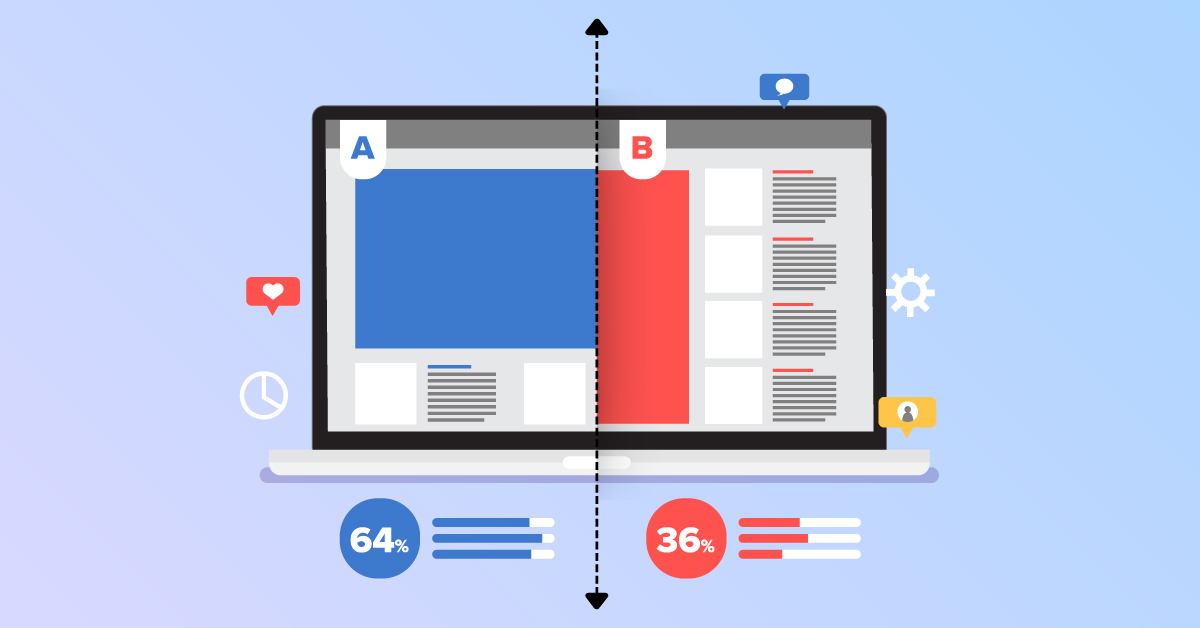

### Loading and processing data <a name="Loading"/>

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns
from scipy.stats import shapiro

In [84]:
path = 'AB_Test_Results.csv'
df = pd.read_csv(path)

In [85]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [86]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [87]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [88]:
df.shape

(10000, 3)

Here we can see there is duplicate data.
- Maby users participation in both of the tests.
- Maybe users participate in a test, but the multi times

In [89]:
# How many users take participate more than 1 times in each group
participation_frequency = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
participation_frequency

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64

In [90]:
# Users how take participte more than 1 times in each group in percentage
participation_frequency / participation_frequency.sum()

VARIANT_NAME
1    0.756325
2    0.243675
Name: count, dtype: float64

As we can see more than 20% of users are suspicious

In [91]:
# Filtrer suspicious users 
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
single_variant_users = single_variant_users[single_variant_users]
df = df[df['USER_ID'].isin(single_variant_users.index)]

In [92]:
# How many users take participate in test to have purchase?
participation_frequency = df.groupby('USER_ID')['REVENUE'].count().value_counts()
participation_frequency

REVENUE
1    3664
2     976
3     122
4      18
5       2
6       1
Name: count, dtype: int64

In [93]:
participation_frequency / participation_frequency.sum()

REVENUE
1    0.766046
2    0.204056
3    0.025507
4    0.003763
5    0.000418
6    0.000209
Name: count, dtype: float64

And more that 20% of users take participate in test more that 1. to create a unique user from them, sum of their revenue is the best approuch.

In [94]:
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

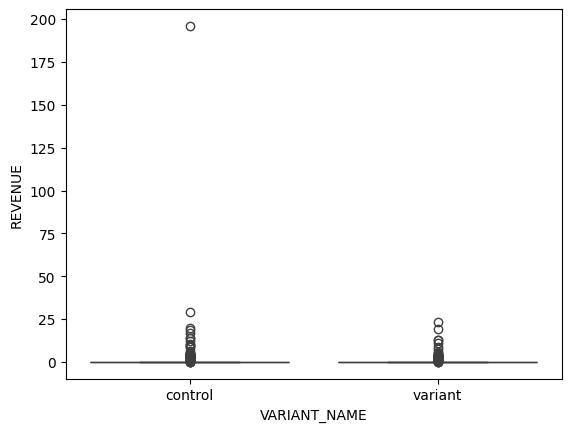

In [97]:
# Revenue distribution for variat and control group
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.show()

As we can see there are some outliers. Let's look closely...

In [98]:
df.sort_values(by='REVENUE', ascending=False).head(10)

,USER_ID,VARIANT_NAME,REVENUE
1601,3342,control,196.01
1054,2166,control,29.32
3511,7356,variant,23.04
514,1053,control,20.07
1779,3684,variant,19.47
137,282,control,18.56
2150,4445,control,17.05
1003,2059,control,14.24
962,1973,control,14.07
2388,4966,variant,12.99


we should keep valuable users as much as posible. so I just eliminate user 3342

In [99]:
df = df[df['USER_ID'] != 3342]

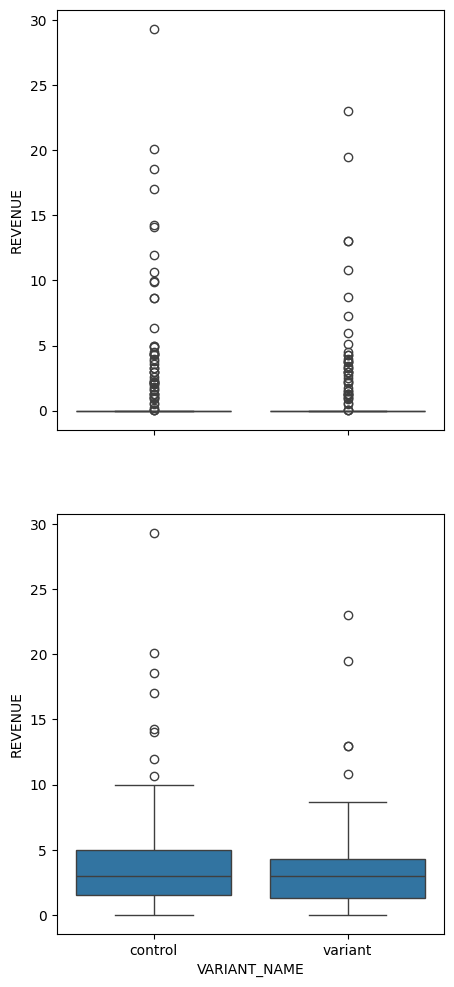

In [100]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))
plt.show()

In [80]:
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

# order per user & revenue per user
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

I'll show the ditribution of the revnue for all users and users who had purchas. we can see the user who had purchase have more iformation. but in the calculate results I consider all the users anyway. Because it is part of the experiment.

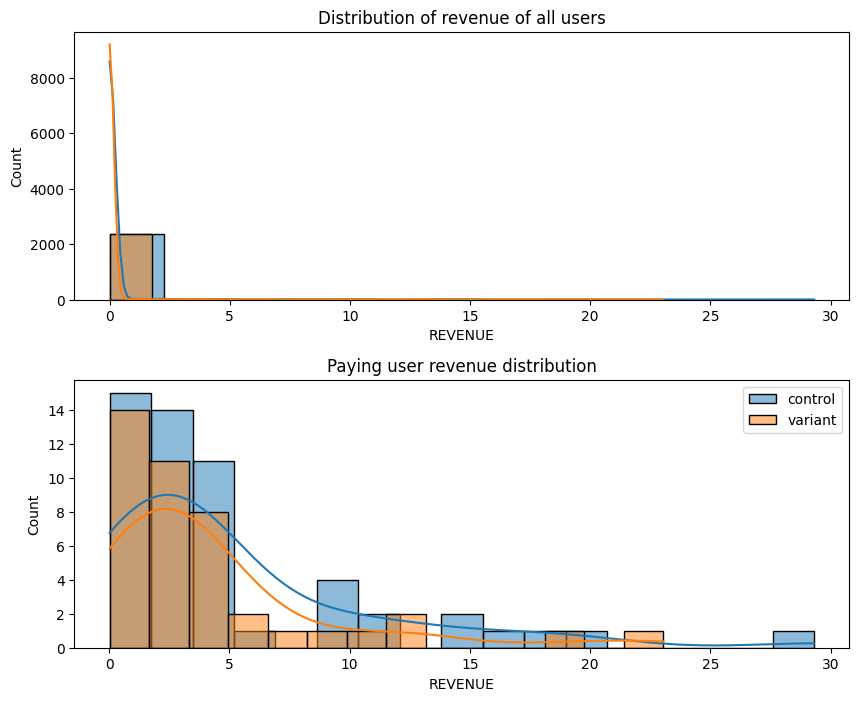

In [134]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.histplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control', kde=True)
sns.histplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant', kde=True)
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.histplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control', kde=True)
sns.histplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant', kde=True)
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

plt.show()

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based previous graph we can see the distribution of the revenue in not normal. To prove this I run the shapiro test

In [112]:
print(shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE']))
print(shapiro(df.loc[df.VARIANT_NAME == 'control', 'REVENUE']))

ShapiroResult(statistic=0.06145977973937988, pvalue=0.0)
ShapiroResult(statistic=0.07461178302764893, pvalue=0.0)


So, the null hypothesis about the normal distribution of the data is rejected

#### Mann-Whitney test

In [118]:
mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821947)

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [131]:
def get_mean_bootstrap(data, n_samples=1000):
    means = []
    for _ in range(n_samples):
        sample = np.random.choice(data, size=n_samples, replace=True)
        means.append(sample.mean())
    return means

Let's generate samples for all users

In [132]:
control_mean_bootstrap = get_mean_bootstrap(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant_mean_bootstrap = get_mean_bootstrap(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

Let's look at the distribution of means in the ab test groups

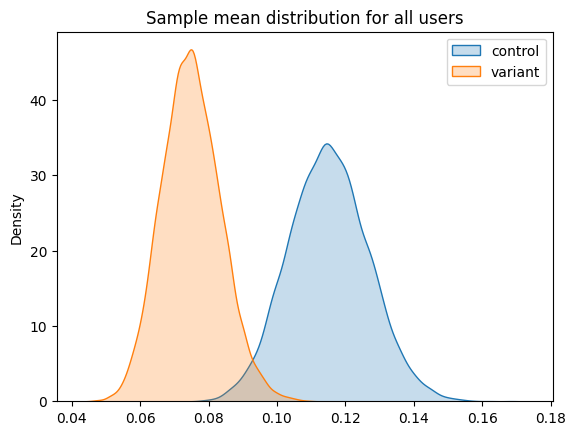

In [133]:
f, ax = plt.subplots()
sns.kdeplot(control_mean_bootstrap, fill=True, label='control', warn_singular=False)
sns.kdeplot(variant_mean_bootstrap, fill=True, label='variant', warn_singular=False)
plt.title('Sample mean distribution for all users')
plt.legend()
plt.show()

Distributions show we have a difference, but in negative direction. out treatment can increase the revenue.

## Lift and confident interval

In [135]:
# Calculate the Mean Revenue
control = df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE']
variant = df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE']

In [140]:
# calculate lift
def calculate_lift(control, treatment):
    lift = (treatment - control) / mean_control * 100 
    return lift


# Calculate Lift Confidence Interval
def calculate_lift_ci(control, treatment, ci=95, num_bootstrap=1000):
    control_means = []
    treatment_means = []
    lifts = []

    for _ in range(num_bootstrap):
        control_sample = np.random.choice(control, size=len(control), replace=True)
        treatment_sample = np.random.choice(treatment, size=len(treatment), replace=True)

        control_mean = control_sample.mean()
        treatment_mean = treatment_sample.mean()

        lift =  (treatment_mean - control_mean) / control_mean * 100 

        control_means.append(control_mean)
        treatment_means.append(treatment_mean)
        lifts.append(lift)


    lift_ci_lower = np.percentile(lifts, (100 - ci) / 2)
    lift_ci_upper = np.percentile(lifts, 100 - (100 - ci) / 2)

    return lift_ci_lower, lift_ci_upper

In [142]:
lift_ci_lower, lift_ci_upper = calculate_lift_ci(control, variant)
print(lift_ci_lower, lift_ci_upper)

-66.53755664519758 20.979766120613164


In [143]:
mean_control = control.mean()
mean_variant = variant.mean()

lift = np.round((mean_variant - mean_control) / mean_control * 100 ,2)

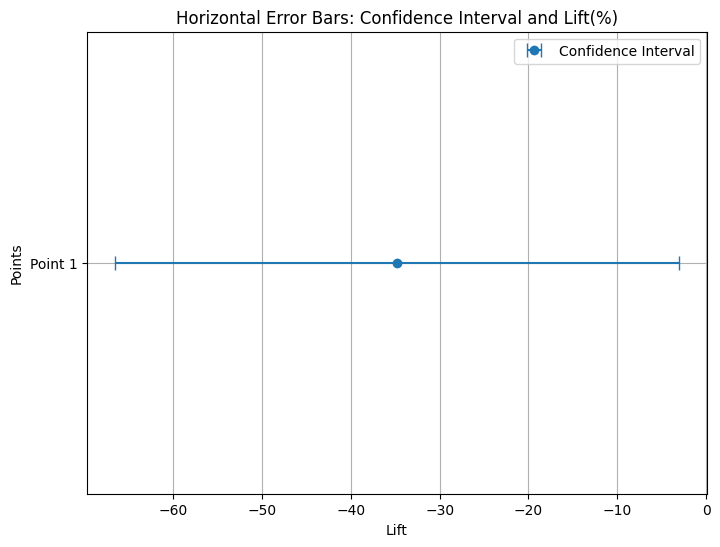

In [144]:
confidence_intervals = [lift - lift_ci_lower]
lift_values = [lift]  

# Calculate error bars for confidence intervals
errors = np.array([[ci, ci] for ci in confidence_intervals]).T

# Plotting
plt.figure(figsize=(8, 6))
plt.errorbar(lift_values, range(len(lift_values)), xerr=errors, fmt='o', capsize=5, label='Confidence Interval')
plt.yticks(range(len(lift_values)), ['Point {}'.format(i) for i in range(1, len(lift_values)+1)])
plt.xlabel('Lift')
plt.ylabel('Points')
plt.title('Horizontal Error Bars: Confidence Interval and Lift(%)')
plt.grid(True)
plt.legend()
plt.show()


## Conclusion
I conduct three aproch to show if there is significant differenc:
- plot the revenue for the treatment and control group (Bootstrap)
- Hypothesis test to show siginificant difference.
- working on lift and confident interval

## Decision making based of lift and confident interval

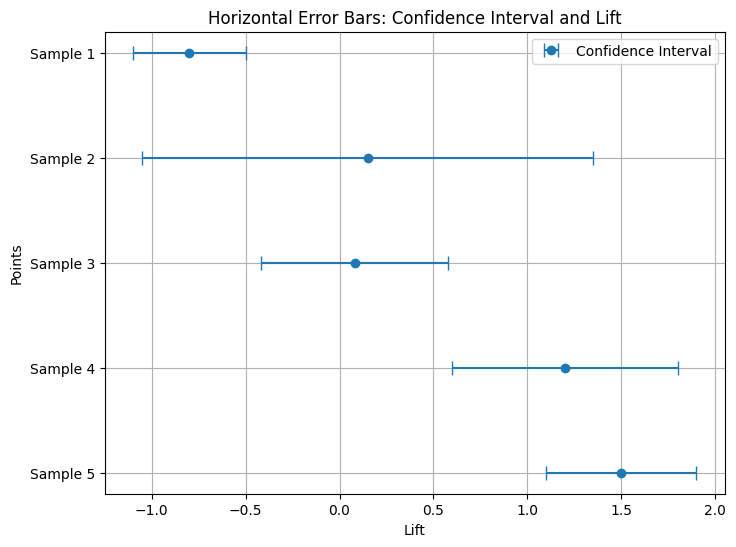

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
confidence_intervals = [0.4, 0.6, 0.5, 1.2, 0.3]  # Example confidence intervals
lift_values = [1.5, 1.2, 0.08, 0.15, -0.8]  # Example lift values

# Calculate error bars for confidence intervals
errors = np.array([[ci, ci] for ci in confidence_intervals]).T

# Plotting
plt.figure(figsize=(8, 6))
plt.errorbar(lift_values, range(len(lift_values)), xerr=errors, fmt='o', capsize=5, label='Confidence Interval')
plt.yticks(range(len(lift_values)), ['Sample {}'.format(i) for i in range(1, len(lift_values)+1)][::-1])
plt.xlabel('Lift')
plt.ylabel('Points')
plt.title('Horizontal Error Bars: Confidence Interval and Lift')
plt.grid(True)
plt.legend()
plt.show()


In working with lift and confident interval of lift there are some situation we can see in the picture about:
1. When lifts are negative and boundaries are narrow: there is no positive view and we should not launch the use of treatment
2. When lifts are positive (and near zero) and boundaries are wide: we can not conclude for using the treatment. it's better to show work another approach.
3. When lift are positive and near zero and boundaries are narrow: having a small confident interval assures us the lift is reliable. so we can conclude both treatment and control are the same.
4. When lift is positive and boundaries are wide: by this result we can use the treatment but the boundaries should not cross zero
5. When lift are positive and boundaries are narrow: we can use treatment easily